In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
#  pd.set_option('display.width', None)

# Ensure full representation of the 'Representation' column
#pd.set_option('display.max_colwidth', None)

In [ ]:
# Load datasets with combined topic modeling results from the topic modeling notebook
GB = pd.read_pickle(r"data folder\GB\GB_final_with_topics.pkl")
AT = pd.read_pickle(r"data folder\AT\AT_final_with_topics_combined.pkl")
HR = pd.read_pickle(r"data folder\HR\HR_final_with_topics_combined.pkl")

# Load topic information dataframes with classifications
# gb_topics = pd.read_pickle(r"data folder\GB\GB_topic_info_classified_english.pkl")
# at_en_topics = pd.read_pickle(r"data folder\AT\AT_topic_info_classified_english.pkl")
# at_de_topics = pd.read_pickle(r"data folder\AT\AT_topic_info_classified_german.pkl")
# hr_en_topics = pd.read_pickle(r"data folder\HR\HR_topic_info_classified_english.pkl")
# hr_hr_topics = pd.read_pickle(r"data folder\HR\HR_topic_info_classified_croatian.pkl")

# load true labels 

hr_labels = pd.read_json("data folder/HR/ParlaCAP-test-hr.jsonl", lines=True)
gb_labels = pd.read_json("data folder/GB/ParlaCAP-test-en.jsonl", lines=True) 


# Drop duplicates in HR and GB based on ID
HR = HR.drop_duplicates(subset=['ID'])
GB = GB.drop_duplicates(subset=['ID'])
AT = AT.drop_duplicates(subset=['ID'])

# Perform the merge
HR = HR.merge(hr_labels[['id', 'labels']], how='left', left_on='ID', right_on='id')
HR.rename(columns={'labels': 'True_label'}, inplace=True)
HR.drop(columns=['id'], inplace=True)

GB = GB.merge(gb_labels[['id', 'labels']], how='left', left_on='ID', right_on='id')
GB.rename(columns={'labels': 'True_label'}, inplace=True)
GB.drop(columns=['id'], inplace=True)


# Load the hdbscan dataframes
GB_hdbscan = pd.read_pickle(r"data folder\GB\GB_with_topics_hdbscan.pkl")
AT_hdbscan = pd.read_pickle(r"data folder\AT\AT_with_topics_hdbscan.pkl")
HR_hdbscan = pd.read_pickle(r"data folder\HR\HR_with_topics_hdbscan.pkl")

# Append my_topic from GB_hdbscan to GB as my_topic_hdbscan
GB['my_topic_hdbscan'] = GB_hdbscan['my_topic']

# Append my_topic_en and my_topic_native_language from HR_hdbscan to HR with _hdbscan suffix
HR['my_topic_en_hdbscan'] = HR_hdbscan['my_topic_en']
HR['my_topic_native_language_hdbscan'] = HR_hdbscan['my_topic_native_language']

AT['my_topic_en_hdbscan'] = AT_hdbscan['my_topic_en']
AT['my_topic_native_language_hdbscan'] = AT_hdbscan['my_topic_native_language']

# HR: Determine topic consensus
def determine_topic_consensus_hr(row):
    topics = [
        row['Segment_Category_HR_english'],
        row['Segment_Category_HR_croatian'],
        row['my_topic_en_hdbscan'],
        row['my_topic_native_language_hdbscan']
    ]
    topics = [topic for topic in topics if topic != 'Other']  # Exclude "Other" from consideration

    if row['Speaker_role'] == 'Chairperson':
        # Chairperson: Only keep non-"Other" if all 4 columns agree
        if len(set(topics)) == 1 and len(topics) == 4:
            return topics[0]
        return 'Other'
    else:
        # Non-chairperson: Determine majority topic
        topic_counts = pd.Series(topics).value_counts()
        if len(topic_counts) == 0:
            return 'Other'  # Default to "Other" if no valid topics
        if topic_counts.iloc[0] > 1:  # Majority exists
            return topic_counts.idxmax()
        if len(topic_counts) > 1 and topic_counts.iloc[0] == topic_counts.iloc[1]:
            return 'Mix'  # Tie between topics
        return topic_counts.idxmax()  # Single most common topic

HR['topic_consensus'] = HR.apply(determine_topic_consensus_hr, axis=1)

# AT: Determine topic consensus
def determine_topic_consensus_at(row):
    topics = [
        row['Segment_Category_AT_english'],
        row['Segment_Category_AT_german'],
        row['my_topic_en_hdbscan'],
        row['my_topic_native_language_hdbscan']
    ]
    topics = [topic for topic in topics if topic != 'Other']  # Exclude "Other" from consideration

    if row['Speaker_role'] == 'Chairperson':
        # Chairperson: Only keep non-"Other" if all 4 columns agree
        if len(set(topics)) == 1 and len(topics) == 4:
            return topics[0]
        return 'Other'
    else:
        # Non-chairperson: Determine majority topic
        topic_counts = pd.Series(topics).value_counts()
        if len(topic_counts) == 0:
            return 'Other'  # Default to "Other" if no valid topics
        if topic_counts.iloc[0] > 1:  # Majority exists
            return topic_counts.idxmax()
        if len(topic_counts) > 1 and topic_counts.iloc[0] == topic_counts.iloc[1]:
            return 'Mix'  # Tie between topics
        return topic_counts.idxmax()  # Single most common topic

AT['topic_consensus'] = AT.apply(determine_topic_consensus_at, axis=1)

# GB: Determine topic consensus
def determine_topic_consensus_gb(row):
    topics = [row['Segment_Category_GB_english'], row['my_topic_hdbscan']]
    topics = [topic for topic in topics if topic != 'Other']  # Exclude "Other" from consideration

    if row['Speaker_role'] == 'Chairperson':
        # Chairperson: Use "Other" unless both topics agree
        if len(set(topics)) == 1 and len(topics) == 2:
            return topics[0]
        return 'Other'
    else:
        # Non-chairperson: Use "Mix" if both topics are non-"Other" and different
        if len(set(topics)) == 2:
            return ['Mix']
        if len(topics) == 1:
            return topics[0]
        return 'Other'

GB['topic_consensus'] = GB.apply(determine_topic_consensus_gb, axis=1)

# shapes
AT.shape, HR.shape, GB.shape

((231759, 38), (504338, 39), (670912, 34))

In [60]:
print(HR['Topic'].value_counts(normalize=True))
print('##########################################')
print(HR['topic_consensus'].value_counts(normalize=True))
print('##########################################')
print(HR['True_label'].value_counts(normalize=True))

print(f"In full HR dataset when role isn't Chairperson % of model predictions 'Other' topic is: {100 * len(HR[(HR['Speaker_role'] != 'Chairperson') & (HR['Topic'] == 'Other')]) / len(HR[HR['Speaker_role'] != 'Chairperson']):.2f}%")
print(f"In full HR dataset when role isn't Chairperson % of my predictions 'Other' topic is: {100 * len(HR[(HR['Speaker_role'] != 'Chairperson') & (HR['topic_consensus'] == 'Other')]) / len(HR[HR['Speaker_role'] != 'Chairperson']):.2f}%")
print('##########################################')

print(GB['Topic'].value_counts(normalize=True))
print('##########################################')
print(GB['topic_consensus'].value_counts(normalize=True))
print('##########################################')
print(GB['True_label'].value_counts(normalize=True))

print(f"In full GB dataset when role isn't Chairperson % of model predictions 'Other' topic is: {100 * len(GB[(GB['Speaker_role'] != 'Chairperson') & (GB['Topic'] == 'Other')]) / len(GB[GB['Speaker_role'] != 'Chairperson']):.2f}%")
print(f"In full GB dataset when role isn't Chairperson % of my predictions 'Other' topic is: {100 * len(GB[(GB['Speaker_role'] != 'Chairperson') & (GB['topic_consensus'] == 'Other')]) / len(GB[GB['Speaker_role'] != 'Chairperson']):.2f}%")

Topic
Other                    0.533376
Government Operations    0.056552
Macroeconomics           0.055627
Mix                      0.050254
Law and Crime            0.033019
Domestic Commerce        0.027986
Civil Rights             0.027516
Health                   0.025864
Agriculture              0.025713
Education                0.022286
Labor                    0.018842
International Affairs    0.017774
Housing                  0.016462
Transportation           0.015601
Social Welfare           0.013256
Defense                  0.013008
Environment              0.011701
Energy                   0.009327
Technology               0.007254
Public Lands             0.006871
Culture                  0.005443
Immigration              0.004711
Foreign Trade            0.001549
-                        0.000008
Name: proportion, dtype: float64
##########################################
topic_consensus
Other                    0.383790
Macroeconomics           0.065149
Mix               

In [3]:
# # HR: Determine topic consensus
# def determine_topic_consensus_hr(row):
#     topics = [
#         row['Segment_Category_HR_english'],
#         row['Segment_Category_HR_croatian'],
#         row['my_topic_en_hdbscan'],
#         row['my_topic_native_language_hdbscan']
#     ]
#     topics = [topic for topic in topics if topic != 'Other']  # Exclude "Other" from consideration

#     if row['Speaker_role'] == 'Chairperson':
#         # Chairperson: Only keep non-"Other" if all 4 columns agree
#         if len(set(topics)) == 1 and len(topics) == 4:
#             return topics[0]
#         return 'Other'
#     else:
#         # Non-chairperson: Determine majority topic
#         topic_counts = pd.Series(topics).value_counts()
#         if len(topic_counts) == 0:
#             return 'Other'  # Default to "Other" if no valid topics
#         if topic_counts.iloc[0] > 1:  # Majority exists
#             return topic_counts.idxmax()
#         if len(topic_counts) > 1 and topic_counts.iloc[0] == topic_counts.iloc[1]:
#             return 'Mix'  # Tie between topics
#         return topic_counts.idxmax()  # Single most common topic

# HR['topic_consensus'] = HR.apply(determine_topic_consensus_hr, axis=1)

# # AT: Determine topic consensus
# def determine_topic_consensus_at(row):
#     topics = [
#         row['Segment_Category_AT_english'],
#         row['Segment_Category_AT_german'],
#         row['my_topic_en_hdbscan'],
#         row['my_topic_native_language_hdbscan']
#     ]
#     topics = [topic for topic in topics if topic != 'Other']  # Exclude "Other" from consideration

#     if row['Speaker_role'] == 'Chairperson':
#         # Chairperson: Only keep non-"Other" if all 4 columns agree
#         if len(set(topics)) == 1 and len(topics) == 4:
#             return topics[0]
#         return 'Other'
#     else:
#         # Non-chairperson: Determine majority topic
#         topic_counts = pd.Series(topics).value_counts()
#         if len(topic_counts) == 0:
#             return 'Other'  # Default to "Other" if no valid topics
#         if topic_counts.iloc[0] > 1:  # Majority exists
#             return topic_counts.idxmax()
#         if len(topic_counts) > 1 and topic_counts.iloc[0] == topic_counts.iloc[1]:
#             return 'Mix'  # Tie between topics
#         return topic_counts.idxmax()  # Single most common topic

# AT['topic_consensus'] = AT.apply(determine_topic_consensus_at, axis=1)

# # GB: Determine topic consensus
# def determine_topic_consensus_gb(row):
#     topics = [row['Segment_Category_GB_english'], row['my_topic_hdbscan']]
#     topics = [topic for topic in topics if topic != 'Other']  # Exclude "Other" from consideration

#     if row['Speaker_role'] == 'Chairperson':
#         # Chairperson: Use "Other" unless both topics agree
#         if len(set(topics)) == 1 and len(topics) == 2:
#             return topics[0]
#         return 'Other'
#     else:
#         # Non-chairperson: Use "Mix" if both topics are non-"Other" and different
#         if len(set(topics)) == 2:
#             return 'Mix'
#         if len(topics) == 1:
#             return topics[0]
#         return 'Other'

# GB['topic_consensus'] = GB.apply(determine_topic_consensus_gb, axis=1)

In [25]:
# # === CATEGORY DISTRIBUTION ANALYSIS ===
# print("📊 Category Distribution Analysis - Segment Counts by Policy Category")
# print("=" * 80)

# # Updated datasets with correct column names from topic modeling notebook
# datasets_to_analyze = [
#     ('GB', GB, 'topic_consensus', 'Topic'),
#     ('HR', HR, 'topic_consensus', 'Topic'),
#     ('AT', AT, 'topic_consensus', 'Topic'),
# ]

# for dataset_name, df, my_topic_col, parlacap_col in datasets_to_analyze:
#     if df is not None and all(col in df.columns for col in [my_topic_col, parlacap_col]):
#         print(f"\n📋 {dataset_name} Analysis:")
        
#         # Calculate percentages for both topic columns
#         topic_percentages = {}
#         total_segments = len(df.dropna(subset=[my_topic_col, parlacap_col]))
        
#         # Our classification
#         topic_percentages[f'Our_{dataset_name}'] = df[my_topic_col].value_counts(normalize=True) * 100
#         # ParlaCAP ground truth
#         topic_percentages[f'ParlaCAP_{dataset_name}'] = df[parlacap_col].value_counts(normalize=True) * 100
        
#         # Combine data into a single DataFrame for plotting
#         combined_data = pd.DataFrame(topic_percentages).fillna(0)
#         combined_data = combined_data.sort_index()
        
#         # Plot the data
#         ax = combined_data.plot(
#             kind='barh',  # Horizontal bar plot
#             figsize=(12, 8), 
#             width=0.8, 
#             alpha=0.8,
#             edgecolor='black'
#         )
        
#         ax.set_title(f'{dataset_name} Topic Distribution Comparison', fontsize=14)
#         ax.set_ylabel('Topics', fontsize=12)
#         ax.set_xlabel('Percentage (%)', fontsize=12)
#         ax.legend(title='Source', fontsize=10)
#         ax.grid(axis='x', alpha=0.3)
#         plt.tight_layout()
#         plt.show()
        
#         print(f"   • Total valid segments: {total_segments:,}")
#     else:
#         print(f"❌ {dataset_name}: Missing columns - {my_topic_col} or {parlacap_col}")

In [5]:
# === POLICY-FOCUSED CONFUSION MATRIX (FLEXIBLE SAMPLING) ===

def analyze_labels(df, evaluation_topic_col, true_label_topic_column,
                   sample_size='all', min_word_count=None, max_word_count=None, 
                   exclude_roles=None, exclude_topics=None, 
                   text_column='Text', plot_size=(16, 12), dataset_name="Dataset"):

    if exclude_roles is None:
        exclude_roles = []
    if exclude_topics is None:
        exclude_topics = []

    # Remove invalid rows
    df = df[~df[true_label_topic_column].isin(['-'])]
    df = df.dropna(subset=[evaluation_topic_col, true_label_topic_column])

    # Filter out specified speaker roles
    if exclude_roles:
        df = df[~df['Speaker_role'].isin(exclude_roles)]

    # Remove specified topic labels
    if exclude_topics:
        for col in [evaluation_topic_col, true_label_topic_column]:
            df = df[~df[col].isin(exclude_topics)]

    # Flexible sampling per CAP label
    if sample_size != 'all':
        sampled_dfs = []
        for category in df[true_label_topic_column].unique():
            category_df = df[df[true_label_topic_column] == category]
            if len(category_df) >= sample_size:
                sampled_dfs.append(category_df.sample(n=sample_size))
            else:
                sampled_dfs.append(category_df)
        df = pd.concat(sampled_dfs, ignore_index=True)

    # Calculate metrics
    my_topics = df[evaluation_topic_col]
    parlacap_topics = df[true_label_topic_column]
    from sklearn.metrics import f1_score
    f1_weighted = f1_score(parlacap_topics, my_topics, average='weighted', zero_division=0)
    f1_macro = f1_score(parlacap_topics, my_topics, average='macro', zero_division=0)
    f1_micro = f1_score(parlacap_topics, my_topics, average='micro', zero_division=0)
    exact_matches = (my_topics == parlacap_topics).sum()
    accuracy_result = exact_matches / len(df)

    # Create confusion matrix
    plt.figure(figsize=plot_size)
    categories = parlacap_topics.value_counts().index.tolist()
    conf_matrix = confusion_matrix(parlacap_topics, my_topics, labels=categories)
    sns.heatmap(conf_matrix, xticklabels=categories, yticklabels=categories, annot=True, fmt='d',
                cmap='Blues', cbar_kws={'label': 'Count'}, square=True, annot_kws={'size': 8},
                linewidths=0.5, linecolor='white')
    plt.title(f'Confusion Matrix for {dataset_name}, f1 scores: macro={f1_macro:.2f}, micro={f1_micro:.2f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'accuracy': accuracy_result,
        'exact_matches': exact_matches,
        'total_speeches': len(df),
        'categories_count': len(categories),
        'sample_size': sample_size,
        'min_word_count': min_word_count,
        'max_word_count': max_word_count,
        'exclude_roles': exclude_roles,
        'exclude_topics': exclude_topics
    }

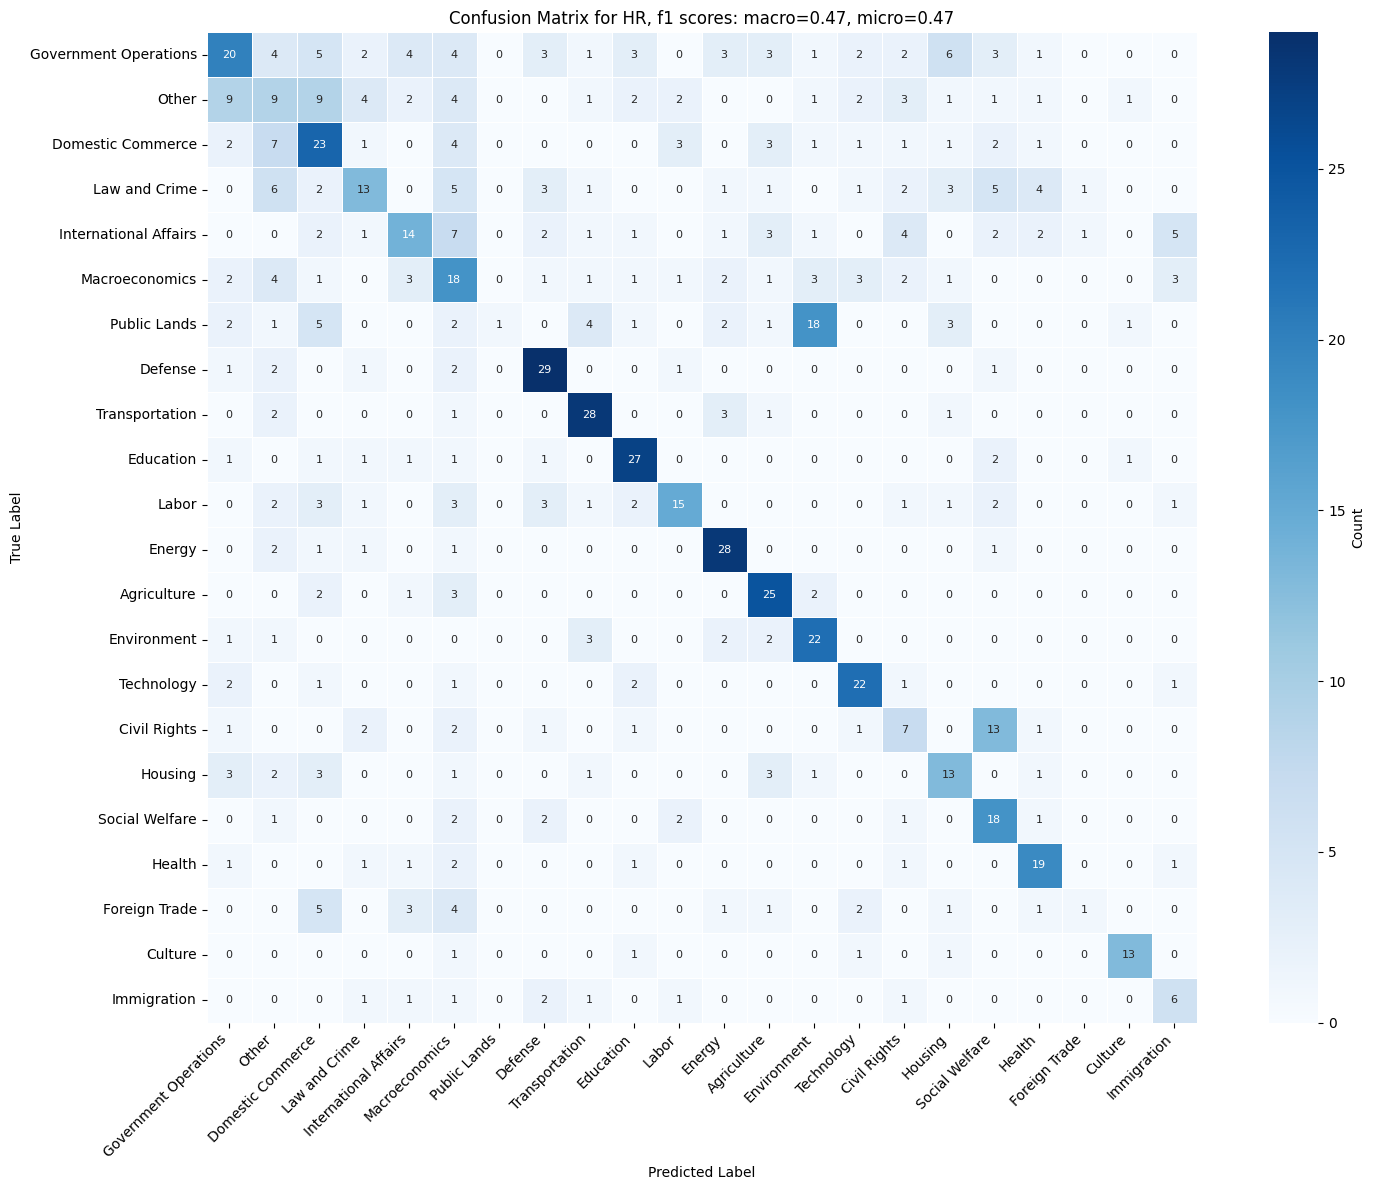

Topic
Other                    0.533376
Government Operations    0.056552
Macroeconomics           0.055627
Mix                      0.050254
Law and Crime            0.033019
Domestic Commerce        0.027986
Civil Rights             0.027516
Health                   0.025864
Agriculture              0.025713
Education                0.022286
Labor                    0.018842
International Affairs    0.017774
Housing                  0.016462
Transportation           0.015601
Social Welfare           0.013256
Defense                  0.013008
Environment              0.011701
Energy                   0.009327
Technology               0.007254
Public Lands             0.006871
Culture                  0.005443
Immigration              0.004711
Foreign Trade            0.001549
-                        0.000008
Name: proportion, dtype: float64
##########################################
topic_consensus
Other                    0.383790
Macroeconomics           0.065149
Mix               

In [ ]:
results_all = {}

# results_all['GB'] = analyze_labels(
#     GB, 'topic_consensus', 'True_label',
#     # exclude_roles=['Chairperson'],
#     exclude_topics=['Other', 'Mix'],
#     dataset_name="GB"
# )

results_all['HR'] = analyze_labels(
    HR, 'topic_consensus', 'True_label',
   # exclude_roles=['Chairperson'],
    exclude_topics=['Mix'],
    dataset_name="HR",
)

In [ ]:
# Calculate speech length and filter middle 50%
HR['speech_length'] = HR['Text'].apply(lambda x: len(str(x).split()))
HR_filtered = HR[HR['speech_length'].between(HR['speech_length'].quantile(0.25), HR['speech_length'].quantile(0.75))]

# Filter rows with true labels
HR_only_true = HR.dropna(subset=['True_label'])

# Total rows with true labels
print(f"Total human annotated rows: {HR_only_true.shape[0]}")
print("##########################################")

# Proportion of 'Other' topics
print(f"Percentage of topic 'Other' in entire dataset: {100 * len(HR[HR['Topic'] == 'Other']) / len(HR):.2f}%")
print(f"Percentage of topic 'Other' in filtered dataset (middle 50% of speeches): {100 * len(HR_filtered[HR_filtered['Topic'] == 'Other']) / len(HR_filtered):.2f}%")
print(f"Percentage of topic 'Other' in test dataset: {100 * len(HR_only_true[HR_only_true['Topic'] == 'Other']) / len(HR_only_true):.2f}%")
print("##########################################")

# Proportion of 'Chairperson' role
print(f"Percentage of 'Chairperson' in entire dataset: {100 * len(HR[HR['Speaker_role'] == 'Chairperson']) / len(HR):.2f}%")
print(f"Percentage of 'Chairperson' in filtered dataset (middle 50% of speeches): {100 * len(HR_filtered[HR_filtered['Speaker_role'] == 'Chairperson']) / len(HR_filtered):.2f}%")
print(f"Percentage of 'Chairperson' in test dataset: {100 * len(HR_only_true[HR_only_true['Speaker_role'] == 'Chairperson']) / len(HR_only_true):.2f}%")
print("##########################################")

# Proportion of model 'Other' topics for Chairperson role
print(f"In test dataset when role is Chairperson % of model predictions 'Other' topic is: {100 * len(HR_only_true[(HR_only_true['Speaker_role'] == 'Chairperson') & (HR_only_true['Topic'] == 'Other')]) / len(HR_only_true[HR_only_true['Speaker_role'] == 'Chairperson']):.2f}%")
print(f"In filtered dataset when role is Chairperson % of model predictions 'Other' topic is: {100 * len(HR_filtered[(HR_filtered['Speaker_role'] == 'Chairperson') & (HR_filtered['Topic'] == 'Other')]) / len(HR_filtered[HR_filtered['Speaker_role'] == 'Chairperson']):.2f}%")
print(f"In full dataset when role is Chairperson % of model predictions 'Other' topic is: {100 * len(HR[(HR['Speaker_role'] == 'Chairperson') & (HR['Topic'] == 'Other')]) / len(HR[HR['Speaker_role'] == 'Chairperson']):.2f}%")
print("##########################################")

# Percentage of true label 'Other' topics for Chairperson role
print(f"Percentage of true label 'Other' for 'Chairperson' in test dataset: {100 * len(HR_only_true[(HR_only_true['Speaker_role'] == 'Chairperson') & (HR_only_true['True_label'] == 'Other')]) / len(HR_only_true[HR_only_true['Speaker_role'] == 'Chairperson']):.2f}%")
print(f"Percentage of model predicted label 'Other' for 'Chairperson' in test dataset: {100 * len(HR_only_true[(HR_only_true['Speaker_role'] == 'Chairperson') & (HR_only_true['Topic'] == 'Other')]) / len(HR_only_true[HR_only_true['Speaker_role'] == 'Chairperson']):.2f}%")
print("##########################################")

# Percentage of role when topic is Other in test dataset
print(f"Percentage of 'Chairperson' role when true label is 'Other' in test dataset: {100 * len(HR_only_true[(HR_only_true['True_label'] == 'Other') & (HR_only_true['Speaker_role'] == 'Chairperson')]) / len(HR_only_true[HR_only_true['True_label'] == 'Other']):.2f}%")
print(f"Percentage of 'Chairperson' role when model label is 'Other' in test dataset: {100 * len(HR_filtered[(HR_filtered['Topic'] == 'Other') & (HR_filtered['Speaker_role'] == 'Chairperson')]) / len(HR_filtered[HR_filtered['Topic'] == 'Other']):.2f}%")

Total human annotated rows: 869
##########################################
Percentage of topic 'Other' in entire dataset: 52.58%
Percentage of topic 'Other' in filtered dataset (middle 50% of speeches): 56.96%
Percentage of topic 'Other' in test dataset: 3.45%
##########################################
Percentage of 'Chairperson' in entire dataset: 48.89%
Percentage of 'Chairperson' in filtered dataset (middle 50% of speeches): 53.66%
Percentage of 'Chairperson' in test dataset: 5.87%
##########################################
In test dataset when role is Chairperson % of model predictions 'Other' topic is: 17.65%
In filtered dataset when role is Chairperson % of model predictions 'Other' topic is: 90.10%
In full dataset when role is Chairperson % of model predictions 'Other' topic is: 93.07%
##########################################
Percentage of true label 'Other' for 'Chairperson' in test dataset: 19.61%
Percentage of model predicted label 'Other' for 'Chairperson' in test dataset:

📊 Topic Distribution Analysis - Our Classification vs ParlaCAP


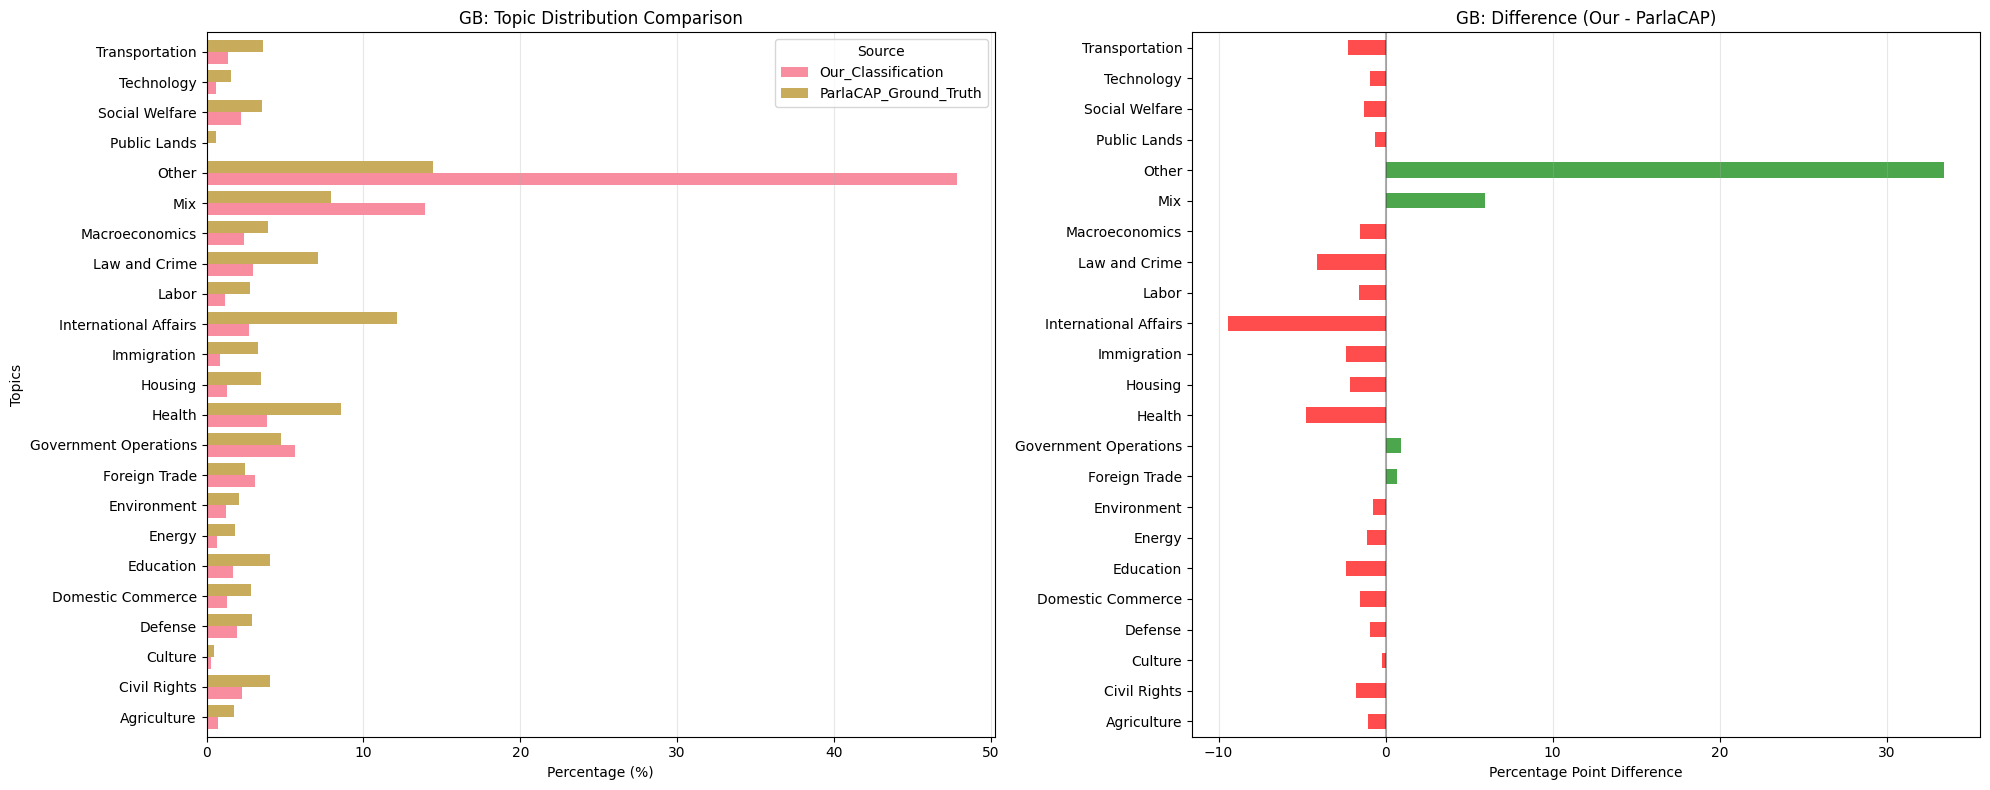


📈 GB - Largest Distribution Differences:


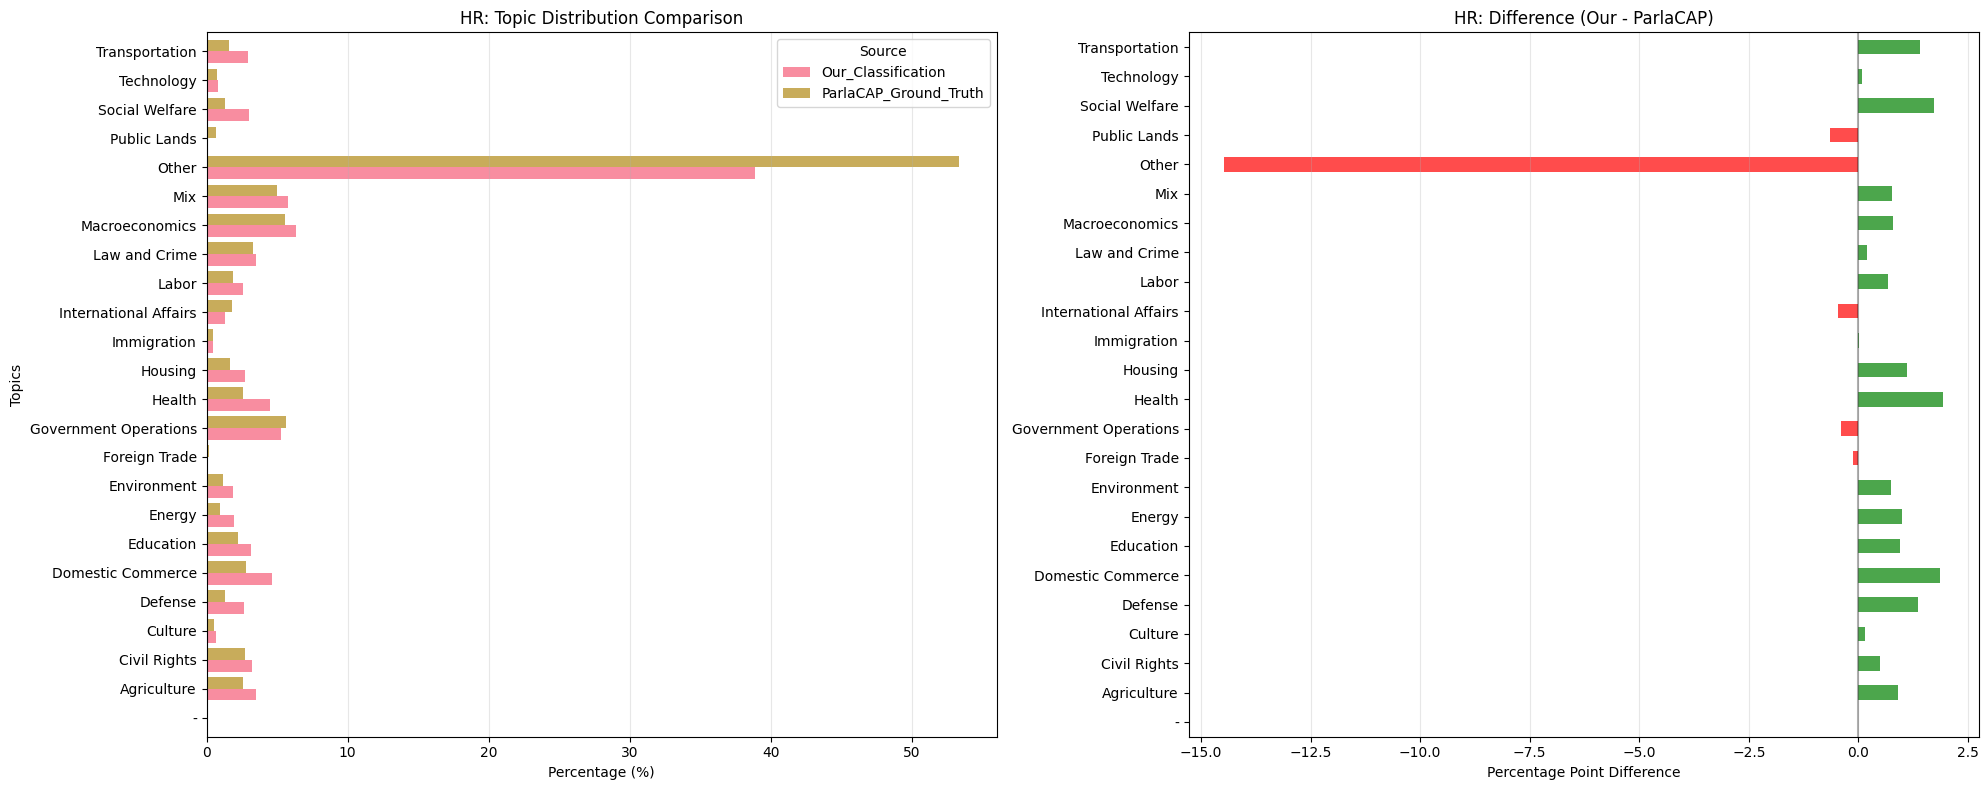


📈 HR - Largest Distribution Differences:


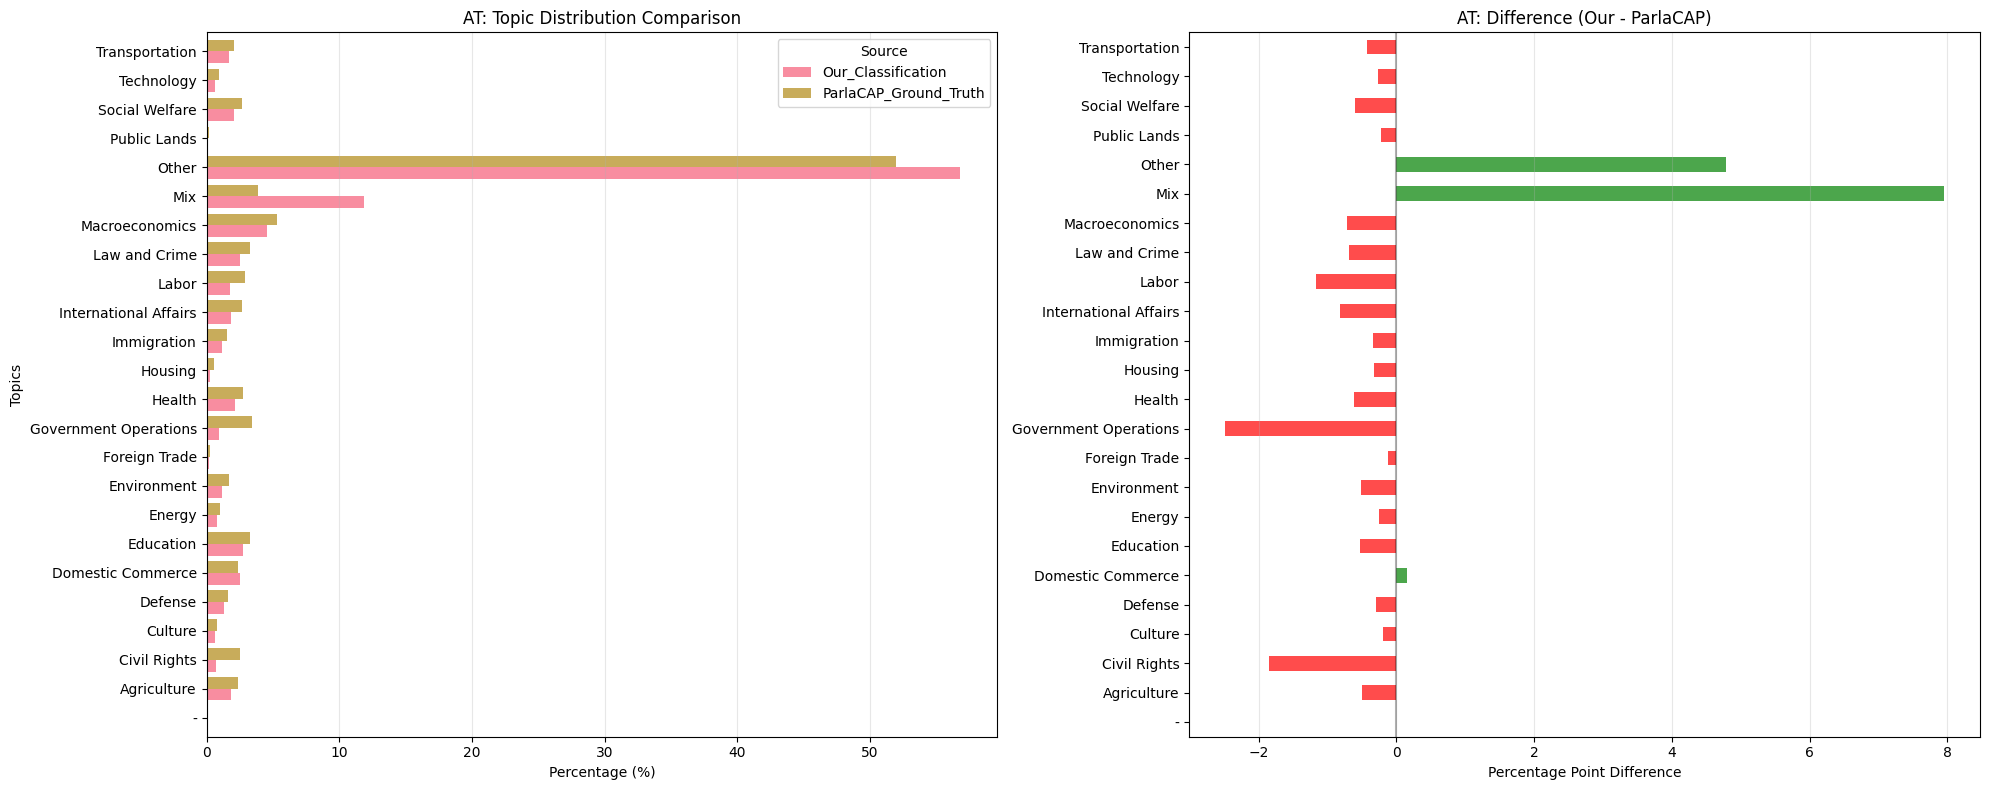


📈 AT - Largest Distribution Differences:


In [33]:
# === TOPIC DISTRIBUTION ANALYSIS ===
print("📊 Topic Distribution Analysis - Our Classification vs ParlaCAP")
print("=" * 70)

def compare_topic_distributions(df, our_col, parlacap_col, dataset_name):
    """Compare distribution of our topics vs ParlaCAP topics"""
    
    # Remove missing data
    clean_df = df.dropna(subset=[our_col, parlacap_col])
    
    # Get distributions
    our_dist = clean_df[our_col].value_counts(normalize=True) * 100
    parlacap_dist = clean_df[parlacap_col].value_counts(normalize=True) * 100
    
    # Combine into comparison DataFrame
    comparison = pd.DataFrame({
        'Our_Classification': our_dist,
        'ParlaCAP_Ground_Truth': parlacap_dist
    }).fillna(0)
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Side-by-side comparison
    comparison.plot(kind='barh', ax=ax1, width=0.8, alpha=0.8)
    ax1.set_title(f'{dataset_name}: Topic Distribution Comparison')
    ax1.set_xlabel('Percentage (%)')
    ax1.set_ylabel('Topics')
    ax1.legend(title='Source')
    ax1.grid(axis='x', alpha=0.3)
    
    # Difference plot
    diff = comparison['Our_Classification'] - comparison['ParlaCAP_Ground_Truth']
    colors = ['red' if x < 0 else 'green' for x in diff]
    diff.plot(kind='barh', ax=ax2, color=colors, alpha=0.7)
    ax2.set_title(f'{dataset_name}: Difference (Our - ParlaCAP)')
    ax2.set_xlabel('Percentage Point Difference')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print top differences
    print(f"\n📈 {dataset_name} - Largest Distribution Differences:")
    top_diffs = diff.abs().nlargest(5)
    for topic, abs_diff in top_diffs.items():
        actual_diff = diff[topic]
        direction = "over-represented" if actual_diff > 0 else "under-represented"

compare_topic_distributions(GB, 'topic_consensus', 'Topic', 'GB')

compare_topic_distributions(HR, 'topic_consensus', 'Topic', 'HR')

compare_topic_distributions(AT, 'topic_consensus', 'Topic', 'AT')
